# TWM Praktikum 5
#### Wintersemester 2020/2021 (Prof. Dr. Markus Döhring)

In [ ]:
# !sudo apt install graphviz -y

In [ ]:
#imports und keras/tensorflow Einstellungen für Reproduzierbarkeit
import numpy as np
import tensorflow as tf
import random as rn
import os
from io import StringIO

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(2)
tf.random.set_seed(3)

from tensorflow import keras
keras.__version__
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from IPython.display import Image, display  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2

import pandas as pd
from tqdm.notebook import tqdm

import json
import numpy
import nltk

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

import textwrap

In [ ]:
# Check if GPU is available

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Deprecated, but still useful
# tf.test.is_gpu_available(cuda_only=True)

# Check if tensorflow-gpu is installed
# pip freeze | grep tensorflow-gpu

In [ ]:
#wir setzen eine globalen Parameter für die maximale Länge von Reviews.
#Alle Reviews, die länger als review_length Wörter sind, werden vor der Modellbildung entsprechend gekürzt 
review_length = 500

#ein weiterer globaler Parameter gibt an, wie groß das Dictionnary sein darf.
#Es werden grundsätzlich die nwords am häufigsten im Corpus vorkommenden Wörter verwendet. 
nwords = 10000


Hinweis: ein Großteil dieses Notebooks basiert auf dem Buch "Deep Learning with Python" (Chollet 2017), insbesondere Kapitel 6, und entsprechend bereitgestelltem Code: https://github.com/fchollet/deep-learning-with-python-notebooks


## 1. IMDB Movie Reviews - Explorative Datenanalyse

In Praktikum 5 arbeiten wir mit dem IMDB Datensatz, der durch Keras bereitgestellt wird. Dieser enthält insgesamt 50.000 stark positiv/negativ geprägte Reviews. Der folgende Python Code liefert 25.000 Reviews (X\_ Arrays) mit entsprechenden Labels (Y\_ Arrays) für das Training und 25.000 Reviews für das Testen eines Modells. 

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=nwords)

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Die von Keras bereitgestellten Datenstrukturen bestehen aus Arrays von Ganzzahlen, die Einträge in einem Lexikon darstellen. Um uns Texte anschauen (oder ggf. textuell weiterverarbeiten) zu können, müssen wir diese "zurückübersetzen", d.h. die Ganzzahlen wieder in Wörter transformieren. Weiterhin kürzen wir die Reviews auf eine in den globelen Parmetern gesetzte Länge. 

In [ ]:
# word_index ist ein dictionnary, das Wörter auf eine Ganzzahl abbildet
word_index = imdb.get_word_index()
# wir kehren den Word Index um und bilden nun Ganzzahlen auf Wörter ab
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Wir dekodieren die Reviews. Achtung: Die Indizes sind um 3 verschoben
# weil 0, 1 and 2 reservierte Indizes für "padding", "start of sequence" und "unknown" sind
X_train = [sequence[0:min(review_length,len(sequence))] for sequence in X_train]
X_test = [sequence[0:min(review_length,len(sequence))] for sequence in X_test]
X_train = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_train[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_train))
]

X_test = [
    ' '.join(
        reverse_word_index.get(i - 3, '?')
        for i in X_test[i]
        if i < len(reverse_word_index)
    ) for i in range(len(X_test))
]

1646592/1641221 [==============================] - 0s 0us/step


### Aufgabe 1: Schauen Sie sich einige Reviews und deren Labels an
Ist ein Datensatz mit 1 gelabelt, dann steht dies fuer einen eher positives Review. Die 0 als Label steht fuer ein eher negatives Review.

In [ ]:
print(y_train)

[1 0 0 ... 0 1 0]


In [ ]:
print(y_train[0])
print('\n'.join(textwrap.wrap(X_train[0], width=100)))



1
? this film was just brilliant casting location scenery story direction everyone's really suited the
part they played and you could just imagine being there robert ? is an amazing actor and now the
same being director ? father came from the same scottish island as myself so i loved the fact there
was a real connection with this film the witty remarks throughout the film were great it was just
brilliant so much that i bought the film as soon as it was released for ? and would recommend it to
everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know
what they say if you cry at a film it must have been good and this definitely was also ? to the two
little boy's that played the ? of norman and paul they were just brilliant children are often left
out of the ? list i think because the stars that play them all grown up are such a big profile for
the whole film but these children are amazing and should be praised for what they have done don't
you t

In [ ]:
print(y_train[2])
print('\n'.join(textwrap.wrap(X_train[2], width=100)))

0
? this has to be one of the worst films of the 1990s when my friends i were watching this film being
the target audience it was aimed at we just sat watched the first half an hour with our jaws
touching the floor at how bad it really was the rest of the time everyone else in the theatre just
started talking to each other leaving or generally crying into their popcorn that they actually paid
money they had ? working to watch this feeble excuse for a film it must have looked like a great
idea on paper but on film it looks like no one in the film has a clue what is going on crap acting
crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life


In [ ]:
print(y_train[5])
print('\n'.join(textwrap.wrap(X_train[5], width=100)))

0
? begins better than it ends funny that the russian submarine crew ? all other actors it's like
those scenes where documentary shots br br spoiler part the message ? was contrary to the whole
story it just does not ? br br


### Aufgabe 2: Identifizieren Sie die relevantesten Features (Wörter) anhand des Chi²-Wertes

In [ ]:
vect = CountVectorizer()
X = vect.fit_transform(X_train)

features = vect.get_feature_names()
(chi2Res, pval) = chi2(X, y_train)

sortedIndex = np.argsort(chi2Res)
sortedIndex = np.flip(sortedIndex)

for i in range(10):
    print(features[sortedIndex[i]], chi2Res[sortedIndex[i]])

bad 3146.5897087158564
worst 1777.4671755725192
great 1492.2652250146114
and 1140.822892867664
awful 1083.9547920433997
waste 1054.7448028673834
no 968.9830866807611
terrible 783.1216389244559
movie 761.6323755468842
excellent 757.1564245810056


### Aufgabe 3: Prüfen und begründen Sie, ob „accuracy“ ein sinnvolles Gütemaß für einen Klassifikator auf diesem Datensatz ist.  

$$
ACC = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [ ]:
unique, counts = numpy.unique(y_train, return_counts=True)
print("Training counts: ", dict(zip(unique, counts)))

unique, counts = numpy.unique(y_test, return_counts=True)
print("Test counts: ", dict(zip(unique, counts)))

# Accuracy is a good measure when the target variable classes in the data are nearly balanced.

Training counts:  {0: 12500, 1: 12500}
Test counts:  {0: 12500, 1: 12500}


## 2. Deep Learning
### 2.1. RNN mit Embeddings


Im folgenden lernen wir ein RNN mit Embeddings Layer über 10 Iterationen (Epochen). Für jede Epoche wird die Performance (accuracy) für die Trainings- und die Validierungsdaten (20%, die vom ursprünglichen Trainingsdatensatz nochmal beiseite gelegt wurden) ausgegeben. Am Ende werden die entsprechenden Werte im Zeitverlauf graphisch dargestellt. 

In [ ]:
from tensorflow.keras.preprocessing import sequence


print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=nwords)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=review_length)
input_test = sequence.pad_sequences(input_test, maxlen=review_length)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [ ]:
%%time
from tensorflow.keras.layers import Dense
tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)
model = Sequential()
model.add(Embedding(nwords, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
"""
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[tbCallBack]
                   )            
"""

CPU times: user 687 ms, sys: 362 ms, total: 1.05 s
Wall time: 5.71 s


In [ ]:
def plothist(hist):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(len(acc))
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()


    plt.show()
    

In [ ]:
plothist(history)


### Aufgabe 4: Wie interpretieren Sie die Performance-Kurven zum RNN bzw. was fällt Ihnen auf?

Der Graph zeigt die Trainings- und Validation-Accuracy im Verlauf über die Epochen. Während die Trainings-Accuracy stetig steigt, zeigt die Validation-Accuracy starke Schwankungen und keinen eindeutigen Trend. Epoche 4 erzielte z.B. deutlich geringere Accuracy bei der Validation.

Basierend auf der Train-Validation Performance entscheiden wir, unser Modell auf den gesamten Trainingsdaten über 4 Epochen zu trainieren. Dann geben wir die Performance auf den Testdaten aus. 

In [ ]:
model.reset_states()

model.fit(input_train, y_train, epochs=3, batch_size=128)
results = model.evaluate(input_test, y_test)
results[1]



Epoch 1/3
196/196 [==============================] - 80s 411ms/step - loss: 0.5285 - acc: 0.7551
Epoch 2/3
196/196 [==============================] - 81s 412ms/step - loss: 0.3516 - acc: 0.8563
Epoch 3/3
782/782 [==============================] - 35s 45ms/step - loss: 0.3714 - acc: 0.8566


0.8565599918365479

### Aufgabe 5: Schauen Sie sich einige der "drastischsten" false positives und false negatives an (hohe Score und Label=1 oder niedrige Score und Label=0). Können Sie erahnen, was das Modell ggf. verwirrt hat?

In [ ]:
preds = model.predict(input_test)

In [ ]:
pred_true_diff = np.absolute(np.subtract(preds.reshape(-1), y_test))

In [ ]:
high_diff_indices = np.argsort(pred_true_diff)
# high_diff_indices = np.flip(high_diff_indices)

In [ ]:
indices = high_diff_indices[-10:]
print("Erroneously predicted reviews")
for i in indices:
    print(f"Review [{i}] // True: [{y_test[i]}] // Predicted: [{preds[i]}] // Difference: [{pred_true_diff[i]}]")
    print('\n'.join(textwrap.wrap(X_test[i], width=100)))
    print()

Erroneously predicted reviews
Review [781] // True: [0] // Predicted: [[0.9941461]] // Difference: [0.9941461086273193]
? a dull ? through the ? of mormon utterly un funny a testament to the widely held theory that in
order for bathroom humor to be funny it must necessarily be vulgar it also ? the claim that a close
relationship with jesus makes you not funny more propaganda than film don't worry about any ? social
issues coming up at the dinner table after this one the saving grace of this movie is its accurate
portrayal of young mormon females as particularly attractive oh well its your 7 50

Review [17582] // True: [0] // Predicted: [[0.99489105]] // Difference: [0.9948910474777222]
? i must admit ashamed though i am that as an ? young teenager this below par horror ? was one of my
favourite all time films nine years after first viewing stephen king's frightening story however i
have now come to my senses and am able to ? fritz work more reasonably br br indeed king's tale of a
smal

### 2.2 RNN mit Glove 50 Layer

Nun trainieren wir ein RNN mit der selben Architektur wie vorher, nur dass wir anstelle eines parallel trainierten 32-dimensionalen Embeddings ein 50-dimensionales, vortrainiertes Word-Embedding verwenden.

In [ ]:
import os
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import requests

embeddings_index = {}

glove6B = 'glove.6B.50d.txt'

if os.path.isfile(glove6B):
    print('Glove tokens file already exists. No need to download it.')
    f = open(glove6B)
else:
    print('Glove tokens file does not exists. Download can take some time.')
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    resp = requests.get(url)
    zipfile = ZipFile(BytesIO(resp.content))
    f = zipfile.open(glove6B)
    #saving it for the next run
    zipfile.extract(glove6B)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

from tensorflow.keras.datasets import imdb
embedding_dim = 50
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((nwords, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < nwords:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Glove tokens file does not exists. Download can take some time.
Found 400000 word vectors.


In [ ]:
%%time
model = Sequential()
model.add(Embedding(nwords, 50))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[tbCallBack]
                   )            


Epoch 1/10
157/157 [==============================] - 67s 423ms/step - loss: 0.6953 - acc: 0.4966 - val_loss: 0.6953 - val_acc: 0.4938
Epoch 2/10
157/157 [==============================] - 68s 434ms/step - loss: 0.6934 - acc: 0.4962 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 3/10
157/157 [==============================] - 70s 448ms/step - loss: 0.6936 - acc: 0.5059 - val_loss: 0.6954 - val_acc: 0.4938
Epoch 4/10
157/157 [==============================] - 67s 426ms/step - loss: 0.6939 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 5/10
157/157 [==============================] - 67s 425ms/step - loss: 0.6939 - acc: 0.5011 - val_loss: 0.6931 - val_acc: 0.5062
Epoch 6/10
157/157 [==============================] - 69s 442ms/step - loss: 0.6941 - acc: 0.4964 - val_loss: 0.6934 - val_acc: 0.4938
Epoch 7/10
157/157 [==============================] - 67s 430ms/step - loss: 0.6940 - acc: 0.4984 - val_loss: 0.6932 - val_acc: 0.4938
Epoch 8/10
157/157 [==============================] - 6

In [ ]:
plothist(history)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.reset_states()
model.fit(input_train, y_train, epochs=3, batch_size=128)
results = model.evaluate(input_test, y_test)
results

Epoch 1/3
196/196 [==============================] - 80s 410ms/step - loss: 0.6932 - acc: 0.5001
Epoch 2/3
196/196 [==============================] - 80s 410ms/step - loss: 0.6934 - acc: 0.4950
Epoch 3/3
782/782 [==============================] - 40s 51ms/step - loss: 0.6931 - acc: 0.5000


[0.6931465864181519, 0.5]

### Aufgabe 6: Optional (nur wenn Sie gut in der Zeit liegen und fit in der Materie sind!): Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum RNN mit vorgelernten Glove-Embedding bzw. was fällt Ihnen auf

### 2.3 LSTM

Nun trainieren wir anstatt eines Modells mit normalen RNN Zellen ein Modell mit LSTM Zellen. Ansonsten bleiben alle anderen Rahmenbedingungen identisch zum Modell unter 2.1

In [ ]:
%%time 
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(nwords, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 7s 38ms/step - loss: 0.5907 - acc: 0.6829 - val_loss: 0.4493 - val_acc: 0.8180
Epoch 2/10
157/157 [==============================] - 6s 35ms/step - loss: 0.3485 - acc: 0.8629 - val_loss: 0.3420 - val_acc: 0.8500
Epoch 3/10
157/157 [==============================] - 6s 35ms/step - loss: 0.2388 - acc: 0.9113 - val_loss: 0.2963 - val_acc: 0.8818
Epoch 4/10
157/157 [==============================] - 6s 36ms/step - loss: 0.2026 - acc: 0.9264 - val_loss: 0.7201 - val_acc: 0.7408
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1888 - acc: 0.9349 - val_loss: 0.3585 - val_acc: 0.8798
Epoch 6/10
157/157 [==============================] - 6s 35ms/step - loss: 0.1495 - acc: 0.9466 - val_loss: 0.3314 - val_acc: 0.8894
Epoch 7/10
157/157 [==============================] - 6s 36ms/step - loss: 0.1315 - acc: 0.9555 - val_loss: 0.3220 - val_acc: 0.8610
Epoch 8/10
157/157 [==============================] - 6s 36ms/step - 

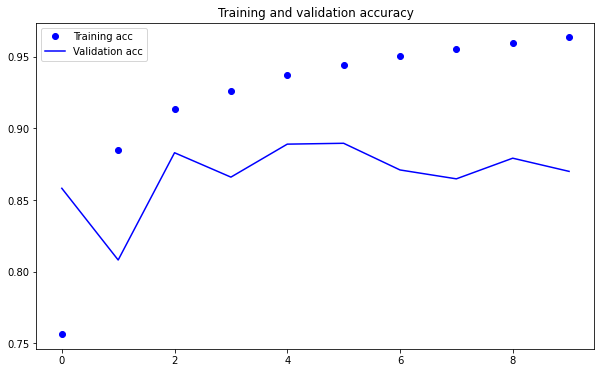

In [ ]:
plothist(history)

In [ ]:
model.reset_states()
model.fit(input_train, y_train, epochs=3, batch_size=128)
results = model.evaluate(input_test, y_test)
results

Epoch 1/3
196/196 [==============================] - 6s 32ms/step - loss: 0.0965 - acc: 0.9679
Epoch 2/3
196/196 [==============================] - 6s 32ms/step - loss: 0.0864 - acc: 0.9715
Epoch 3/3
782/782 [==============================] - 10s 13ms/step - loss: 0.4328 - acc: 0.8624


[0.43280643224716187, 0.8623600006103516]

### Aufgabe 7: Wie interpretieren Sie die Performance-Kurven und Ergebnisse auf den Testdaten zum LSTM bzw. was fällt Ihnen auf?

Auch bei LSTM steigt die Trainings-Accuracy stetig. Im Gegensatz zu der Performance-Kurve des RNNs schwankt hier die Validation-Accuracy nur in den frühen Epochen stark. In den späteren Epochen sind nur noch leichte Schwankungen zu erkennen.

Dieses Verhalten ist dadurch zu erklären, dass bei späteren Epochen auf ausreichend Informationen im Memory zugegriffen werden kann, was zur Stabilisierung der Accuracy beiträgt.

Die Ergebnisse auf den Testdaten sind etwas besser, als bei dem RNN.


## 3. Not So Deep Learning

Im folgenden verwenden wir sehr einfache Klassifikationsmodelle: Eine logistische Regression (siehe ggf. Wikipedia o.ä.) und einen Decision Tree aufbauend auf TF-IDF gewichteten Unigrammen+Bigrammen. 

## Logistische Regression

In [ ]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('log', LogisticRegression())
])

model.fit(X_train, y_train)

CPU times: user 23.3 s, sys: 9.74 s, total: 33 s
Wall time: 22.7 s


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12319
           1       0.89      0.88      0.89     12681

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

0.88588


In [ ]:
# Ausgabe der Features sortiert nach ihren Koeffizienten innerhalb des LogReg Modells
print('Negativ')
for x in np.array(model.named_steps['tfidf'].get_feature_names())[np.argsort(model.named_steps['log'].coef_[0])][0:10]:
    print(x)

print('\nPositiv')
for x in np.array(model.named_steps['tfidf'].get_feature_names())[np.argsort(model.named_steps['log'].coef_[0])][-10:]:
    print(x)

Negativ
bad
worst
the worst
awful
boring
no
waste
poor
nothing
terrible

Positiv
amazing
well
perfect
the best
love
best
wonderful
and
excellent
great


## Decision Tree

In [ ]:
%%time
model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=4))
])

model.fit(X_train, y_train)

CPU times: user 16.8 s, sys: 33.7 ms, total: 16.8 s
Wall time: 16.8 s


In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))
print((y_pred == y_test).mean())

              precision    recall  f1-score   support

           0       0.48      0.83      0.61      7238
           1       0.90      0.63      0.74     17762

    accuracy                           0.69     25000
   macro avg       0.69      0.73      0.68     25000
weighted avg       0.78      0.69      0.71     25000

0.69128


In [ ]:
dot_data = StringIO()

export_graphviz(model.named_steps['tree'], out_file=dot_data, filled=True, rounded=True, special_characters=True)

splitArgs = model.named_steps['tree'].tree_.feature.tolist()

dot_data = dot_data.getvalue()

print('Das sind die Splitargumente des DecisionTrees:')

for x in ([arg for arg in splitArgs if arg != -2 ]):
    rep = model.named_steps['tfidf'].get_feature_names()[x] 
    dot_data = dot_data.replace('X<SUB>'+str(x)+'</SUB>', str(rep))
    print(rep)

Das sind die Splitargumente des DecisionTrees:
bad
worst
waste
awful
city
worst
beautiful
incredible
great
worst
bad
excellent
worst
bad
out for


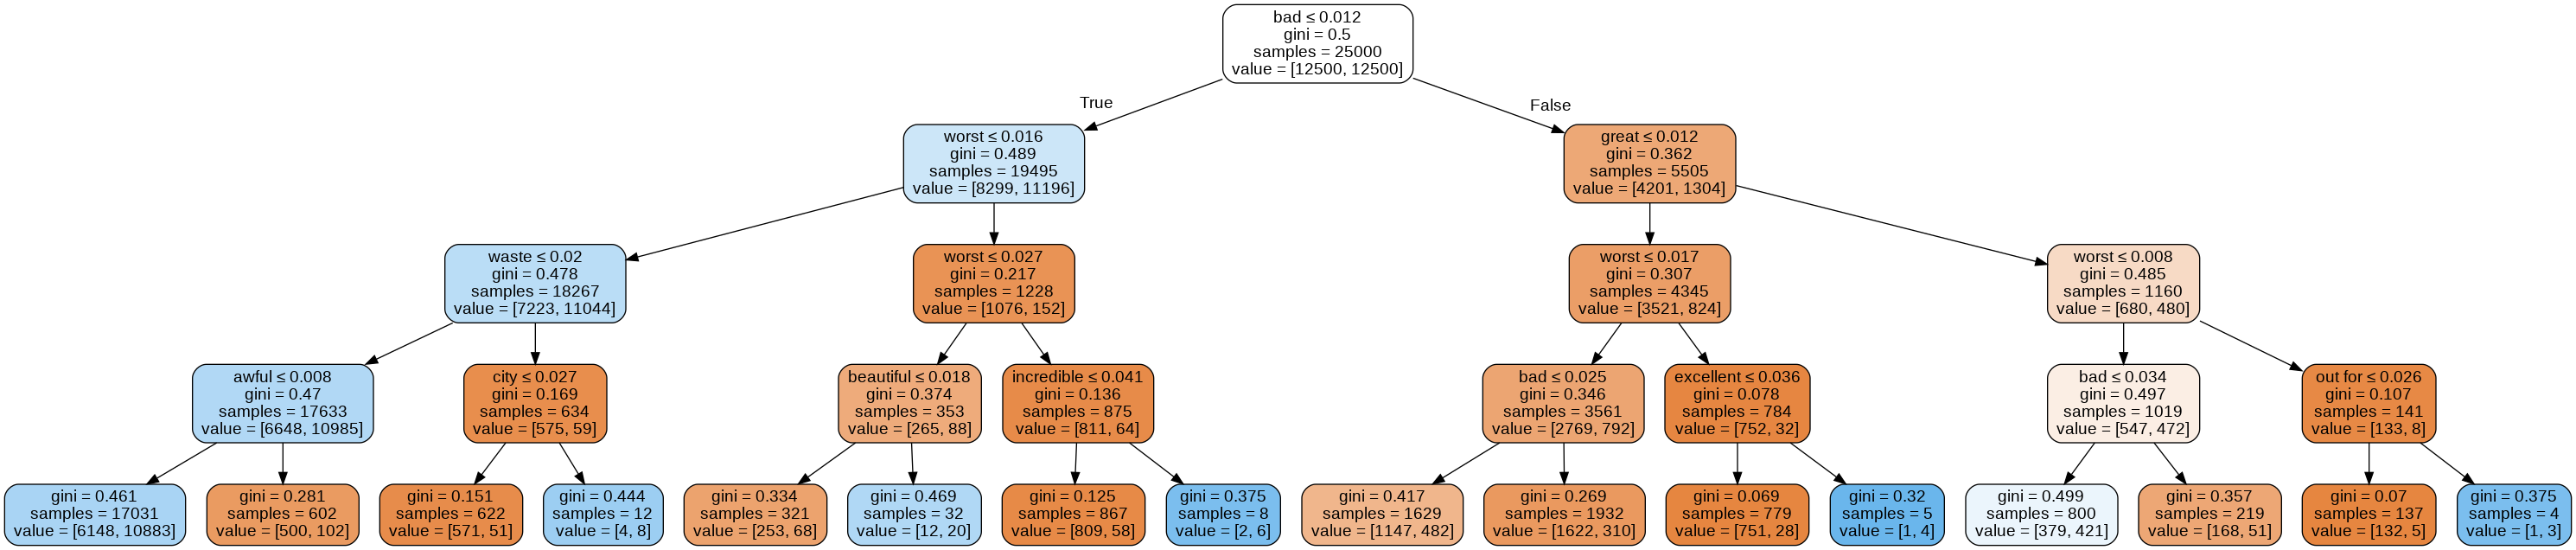

In [ ]:
%matplotlib notebook
# Falls Sie https://www.graphviz.org/ installiert haben, koennen Sie den Decision Tree auch plotten
# In der twm VM koennen Sie graphviz mit: sudo apt-get -y install graphviz
# installieren
try:
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png()))
except:
    print('graphviz ist nicht installiert')

### Aufgabe 8: Wie interpretieren Sie die Ergebnisse der "einfacheren" Klassifikationsmodelle auf den Testdaten bzw. was fällt Ihnen auf? Inwiefern deckt sich die Wichtigkeit der Features mit der, die Sie in Aufgabe (2) ermittelt haben?

**Logisische Regression**

Bei der Unterscheidung in gute und schlechte Reviews kann die logistische Regression mit den Neuronalen Netzen mithalten. Die Accuracy auf den Testdaten ist sogar etwas höher als die des RNNs und LSTMs.

Viele der in Aufgabe (2) ermittelten wichtigen Features finden sich unter den für die Regression wichtigen Features wieder.

**Decision Tree**

Der Decision Tree erzielt auf den Testdaten eine deutlich geringere Accuracy, als die restlichen Verfahren. 

Unter den Splitargumenten finden sich allerdings auch viele der Features aus Aufgabe (2) wieder. 

